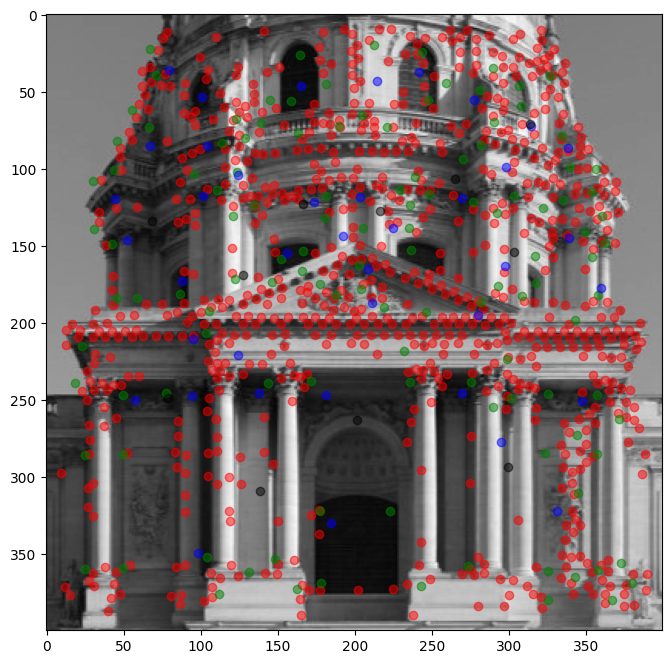

Candidate Keypoint = 973


In [15]:
import numpy as np
from scipy.ndimage import convolve
import numpy.linalg as LA
from skimage import data, filters, color
from skimage import io
import matplotlib.pyplot as plt
import cv2

def gaussian_filter(sigma):
  size = 2*np.ceil(3*sigma)+1
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

def generate_octave(init_level, s, sigma):
  octave = [init_level]
  k = 2**(1/s)
  kernel = gaussian_filter(k * sigma)
  for _ in range(s+2):
    next_level = convolve(octave[-1], kernel)
    octave.append(next_level)
  return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma):
  pyr = []
  for _ in range(num_octave):
    octave = generate_octave(im, s, sigma)
    pyr.append(octave)
    im = octave[-3][::2, ::2]
  return pyr

def generate_DoG_octave(gaussian_octave):
  octave = []
  for i in range(1, len(gaussian_octave)):
    octave.append(gaussian_octave[i] - gaussian_octave[i-1])
  return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
  pyr = []
  for gaussian_octave in gaussian_pyramid:
    pyr.append(generate_DoG_octave(gaussian_octave))
  return pyr

def get_candidate_keypoints(D, w=16):
  candidates = []
  D[:,:,0] = 0
  D[:,:,-1] = 0
  for i in range(w//2+1, D.shape[0]-w//2-1):
    for j in range(w//2+1, D.shape[1]-w//2-1):
      for k in range(1, D.shape[2]-1):
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
        if np.argmax(patch) == 13 or np.argmin(patch) == 13:
          candidates.append([i, j, k])
  return candidates


def localize_keypoint(D, x, y, s):
    dx = (D[y,x+1,s] - D[y,x-1,s]) / 2.0
    dy = (D[y+1,x,s] - D[y-1,x,s]) / 2.0
    ds = (D[y,x,s+1] - D[y,x,s-1]) / 2.0
    dxx = D[y,x+1,s] - 2.0 * D[y,x,s] + D[y,x-1,s]
    dxy = (D[y+1,x+1,s] - D[y+1,x-1,s] - D[y-1,x+1,s] + D[y-1,x-1,s]) / 4.0
    dxs = (D[y,x+1,s+1] - D[y,x-1,s+1] - D[y,x+1,s-1] + D[y,x-1,s-1]) / 4.0
    dyy = D[y+1,x,s] - 2.0 * D[y,x,s] + D[y-1,x,s]
    dys = (D[y+1,x,s+1] - D[y-1,x,s+1] - D[y+1,x,s-1] + D[y-1,x,s-1]) / 4.0
    dss = D[y,x,s+1] - 2.0 * D[y,x,s] + D[y,x,s-1]

    J = np.array([dx, dy, ds])
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    offset = -LA.inv(HD).dot(J)

    return offset, J, HD[:2,:2], x, y, s


def find_keypoints_for_DoG_octave(D, R_th, t_c, w, offset_th=0.5):
    candidates = get_candidate_keypoints(D, w)
    keypoints = []
    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        if np.any(np.abs(offset) > offset_th):
            continue

        contrast = D[y,x,s] + .5*J.dot(offset)
        if abs(contrast) < t_c:
            continue

        w, v = LA.eig(H)
        if np.any(w == 0):
            continue

        r = w[1]/w[0]
        R = (r+1)**2 / r
        if R > R_th:
            continue

        kp = np.array([x, y, s]) + offset
        keypoints.append(kp)

    return np.array(keypoints)


def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []
    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))
    return kps

def get_candidate_keypoints_integrate(DoG_pyr, w):
    kps = []

    for D in DoG_pyr:
        candidates = get_candidate_keypoints(D, w)
        keypoints = []
        for i, cand in enumerate(candidates):
            y, x, s = cand[0], cand[1], cand[2]
            keypoints.append(np.array([x, y, s]))
        kps.append(np.array(keypoints))
    return kps

def myDrawKeypoints(image, kps):
    fig, axs = plt.subplots(1, 1, figsize=(12, 8))
    axs.imshow(image, cmap='gray')
    h = image.shape[0]
    colors = ['red', 'green', 'blue', 'black']

    for o in range(len(kps)):
        if len(kps[o]) == 0:
            continue
        kpso = kps[o]*(2**o)
        for pt in kpso:
            axs.scatter(pt[0], pt[1], color=colors[o], alpha = 0.5)

    plt.show()

gimage = cv2.imread('/content/drive/MyDrive/Image/architect2_400.jpg')
gimage = cv2.cvtColor(gimage, cv2.COLOR_BGR2GRAY)
gimage = gimage / 255.0

kernel = gaussian_filter(1.3)
gray_image = convolve(gimage, kernel)
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)

R_th = (10+1)**2 / 10
kps = get_keypoints(dog_pyramid, R_th, t_c=0.01, w=16)

myDrawKeypoints(gimage, kps)

print('Candidate Keypoint =', sum(np.array([len(kps[o]) for o in range(len(kps))])))



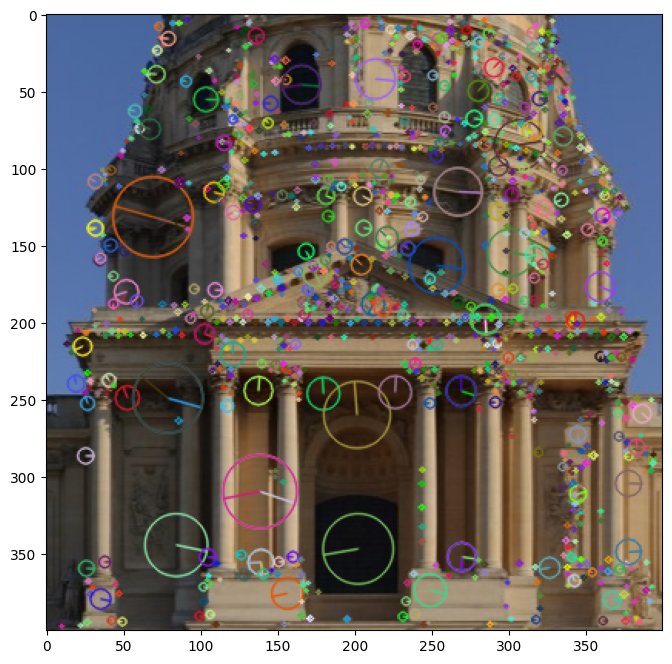

In [16]:
import cv2

src = cv2.imread('/content/drive/MyDrive/Image/architect2_400.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

siftF = cv2.SIFT.create(edgeThreshold=10)
kp_from_sift = siftF.detect(gray)

dst = cv2.drawKeypoints(src, kp_from_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()